In [45]:
pip_list = !pip list
packages = ["dabl", "imblearn", "keras-tuner", "mysql-connector-python", "numpy", "pandas", "sklearn", "tensorflow"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

Package installations completed.


In [46]:
import calendar
import datetime
import os
import shutil
import warnings
from pickle import dump

import chardet
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import requests
import scipy.stats as stat
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from dabl import SimpleClassifier, SimpleRegressor, clean, plot
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from mysql.connector import errorcode
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.datasets import (load_breast_cancer, load_diabetes, load_iris,
                              load_wine)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (SelectPercentile, VarianceThreshold,
                                       chi2, f_classif)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder,
                                   StandardScaler)
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7975707335975460609
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17345691043555243943
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
0
MemTotal:       16393696 kB
0
Tue May 31 02:33:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. 

2022-05-31 02:33:51.780680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 02:33:51.781685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 02:33:51.782443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 02:33:51.783296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 02:33:51.784017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [47]:
# try:
#     conn = mysql.connector.connect(
#         user="admin",
#         password=os.environ["MYSQL_DB_CONN"],
#         host="host.mysql.database.azure.com",
#         port=3306,
#         database="",
#         ssl_ca="{ca-cert filename}",
#         ssl_disabled=False,
#     )
#     print("Connection established")
# except mysql.connector.Error as e:
#     if e.errno == errorcode.ER_ACCESS_DENIED_ERROR:
#         print("Something is wrong with the user name or password")
#     elif e.errno == errorcode.ER_BAD_DB_ERROR:
#         print("Database does not exist")
#     else:
#         print(e)
# else:
#     tables = {table: pd.read_sql(f"""SELECT * FROM {table};""", conn) for table in pd.read_sql("SHOW TABLES", conn).iloc[:, 0]}
#     for table_name, table_dataframe in tables.items():
#         print(f"-------------------------------------------------------\nTable: {table_name}")
#         display(table_dataframe)
#     conn.close()
#     print(f"Discovered table(s): {len(tables)}.\nDB Connection closed.")
# for table_name, table_dataframe in tables.items():
#     print(f"-------------------------------------------------------\nTable: {table_name}\nColumns: {table_dataframe.columns}\nShape: {table_dataframe.shape}")
# df.rename({"": ""}, axis=1, inplace=True)
# df = pd.merge(tables[""], tables[""], on="")
# df = pd.merge(df, tables[""], on="")
# display(df)

In [49]:
try:
    conn = mysql.connector.connect(
        user="admin",
        password=os.environ["MYSQL_DB_CONN"],
        host="host.mysql.database.azure.com",
        port=3306,
        database="",
        ssl_ca="{ca-cert filename}",
        ssl_disabled=False,
    )
    print("Connection established")
except mysql.connector.Error as e:
    if e.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with the user name or password")
    elif e.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(e)
else:
    tables = {table: pd.read_sql(f"""SELECT * FROM {table};""", conn) for table in pd.read_sql("SHOW TABLES", conn).iloc[:, 0]}
    for table_name, table_dataframe in tables.items():
        print(f"-------------------------------------------------------\nTable: {table_name}")
        display(table_dataframe)
    conn.close()
    print(f"Discovered table(s): {len(tables)}.\nDB Connection closed.")
for table_name, table_dataframe in tables.items():
    print(f"-------------------------------------------------------\nTable: {table_name}\nColumns: {table_dataframe.columns}\nShape: {table_dataframe.shape}")
df.rename({"": ""}, axis=1, inplace=True)
df = pd.merge(tables[""], tables[""], on="")
df = pd.merge(df, tables[""], on="")
display(df)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.00,22,11628.00,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.00,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.00,19,7450.00,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.00,19,17780.00,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.00,16,10404.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,C4,845,Rented,Individual,22,22,No,X3,NaN,NaN,18,7704.00,0
50878,50879,C5,4188,Rented,Individual,27,27,No,X3,7.0,3.00,4,5408.00,0
50879,50880,C1,442,Rented,Individual,63,63,No,X2,14+,1.00,12,11374.00,0
50880,50881,C1,4,Owned,Joint,71,49,No,X2,2.0,2.00,16,28179.20,1


In [50]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 0
SCALER = 1
CLASSIFICATION = 0

print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))
y_label = "Reco_Policy_Premium"

-------------------------------------------------------
Current Shape: (50882, 14).
-------------------------------------------------------
Duplicates Percentage: 0.00%
Duplicates have been removed (50882, 14).


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
45645,45646,C6,3170,Owned,Individual,34,34,No,X1,1.0,3.00,22,7440.00,0
49060,49061,C2,673,Owned,Individual,51,51,No,X1,14+,2.00,14,15782.00,1
50136,50137,C1,3678,Owned,Individual,56,56,No,X1,10.0,3.00,18,15548.00,0


In [51]:
df.dropna(subset=[y_label], inplace=True)
print("-------------------------------------------------------")
print(f"Dropping null target values.")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"y Value Counts:\n{df[y_label].value_counts()}")

-------------------------------------------------------
Dropping null target values.
Current Shape: (50882, 14).
-------------------------------------------------------
y Value Counts:
10080.00    61
11880.00    59
12060.00    58
9296.00     56
11520.00    54
            ..
32886.00     1
33804.00     1
18072.00     1
20566.00     1
11374.00     1
Name: Reco_Policy_Premium, Length: 6977, dtype: int64


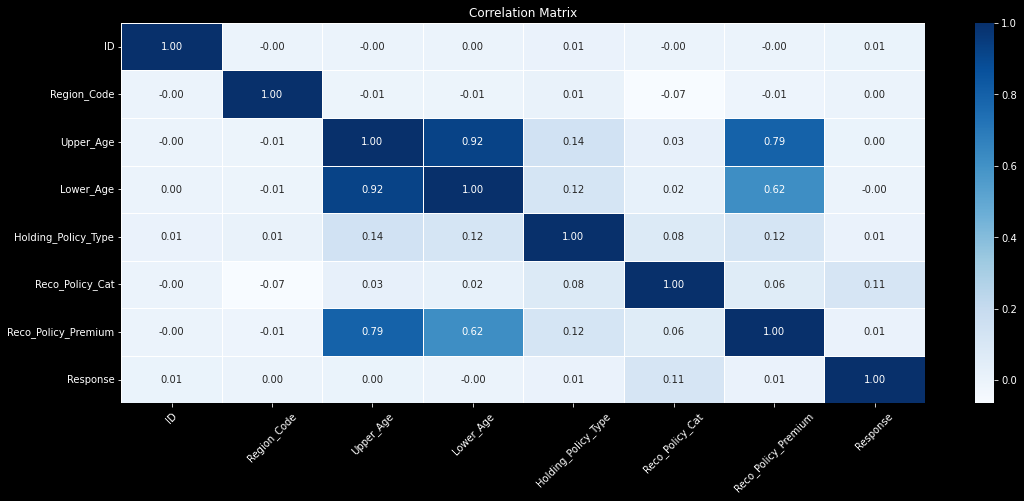

In [52]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

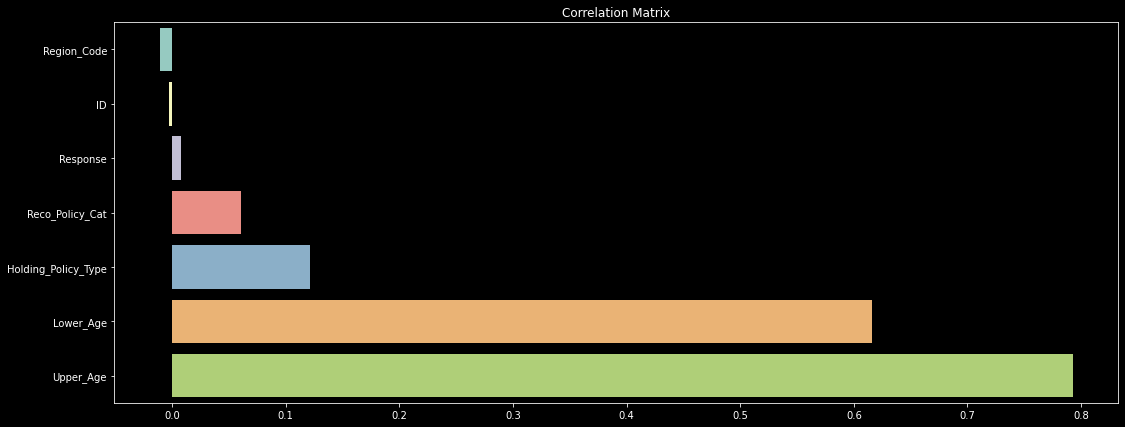

In [53]:
corr_matrix = df.corr()[y_label].sort_values().drop(y_label)
sns.barplot(x=corr_matrix.values, y=corr_matrix.index).set_title("Correlation Matrix")
plt.show()

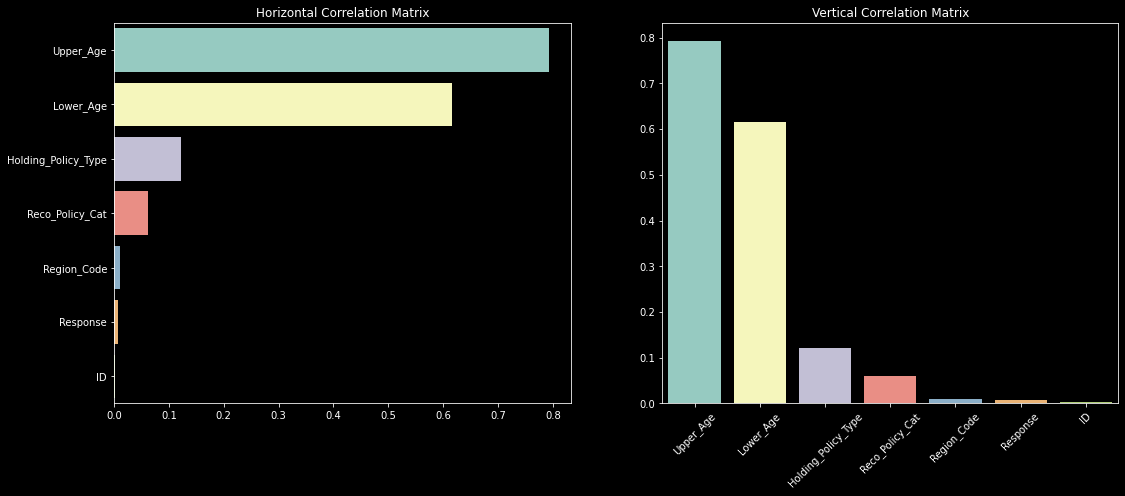

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2)
corr_matrix = df.corr()[y_label].abs().sort_values(ascending=False).drop(y_label)
sns.barplot(x=corr_matrix.values, y=corr_matrix.index, ax=ax[0]).set_title("Horizontal Correlation Matrix")
sns.barplot(x=corr_matrix.index, y=corr_matrix.values, ax=ax[1]).set_title("Vertical Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

In [55]:
def correlation(X, threshold):
    col_corr = set()
    df_corr = X.corr().abs()
    for i, _ in enumerate(df_corr.columns):
        for j in range(i):
            if (df_corr.iloc[i, j] >= threshold) and (
                df_corr.columns[j] not in col_corr
            ):
                col_corr.add(df_corr.columns[i])
    return col_corr

col_drop = correlation(df.drop(y_label, axis=1), 0.85)
df.drop(col_drop, inplace=True, axis=1)
print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Highly correlated cols have been removed: {len(col_drop)}.")
print(f"Highly correlated cols: {col_drop}.")

-------------------------------------------------------
Current Shape: (50882, 13).
-------------------------------------------------------
Highly correlated cols have been removed: 1.
Highly correlated cols: {'Lower_Age'}.


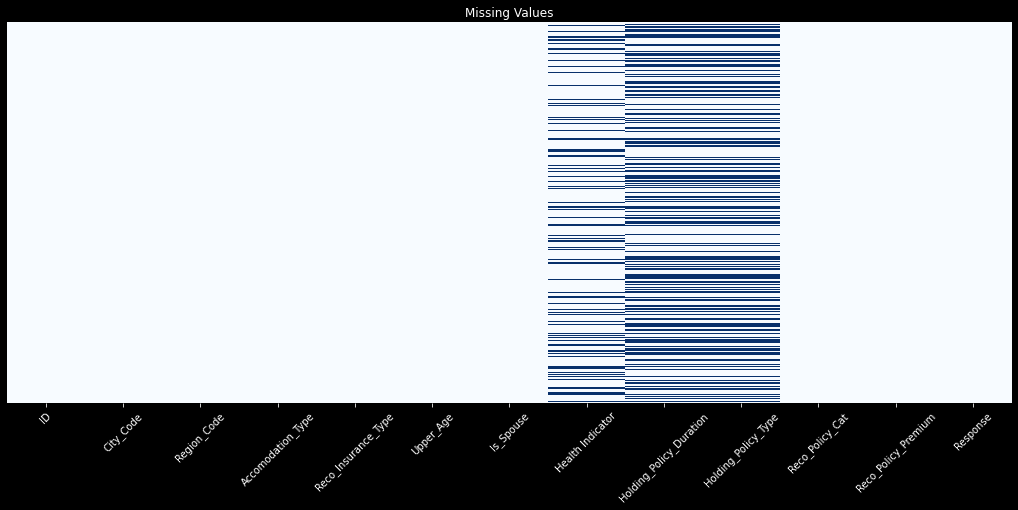

In [56]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")
plt.title("Missing Values")
plt.xticks(rotation=45)
plt.show()

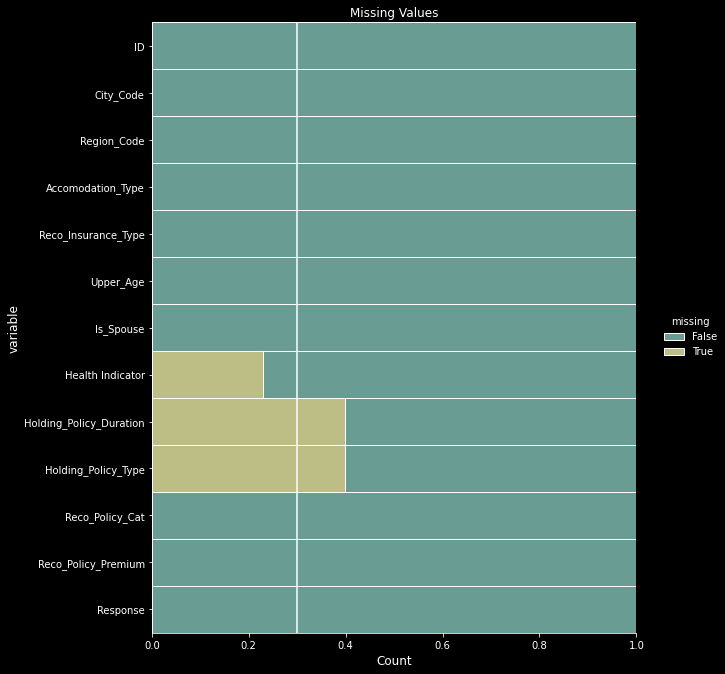

In [57]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()

In [58]:
"""
%a: Weekday, abbreviated: Mon, Tues, Sat
%A: Weekday, full name: Monday, Tuesday, Saturday
%w: Weekday, decimal. 0=Sunday: 1, 2, 6
%d: Day of month, zero-padded: 01, 02, 21
%b: Month, abbreviated: Jan, Feb, Sep
%B: Month, full name: January, February, September
%m: Month number, zero-padded: 01, 02, 09
%y: Year, without century, zero-padded: 02, 95, 99
%Y: Year, with century: 1990, 2020
%H: Hour (24 hour), zero padded: 01, 22
%I: Hour (12 hour) zero padded: 01, 12
%p: AM or PM: AM, PM
%M: Minute, zero-padded: 01, 02, 43
%S: Second, zero padded: 01, 32, 59
%f: Microsecond, zero-padded: 000001, 000342, 999999
%z: UTC offset ±HHMM[SS[.ffffff]]: +0000, -1030, -3423.234
%Z: Time zone name: ITC, EST, CST
%j: Day of year, zero-padded: 001, 365, 023
%U: Week # of year, zero-padded. Sunday first day of week: 00, 01, 51
%W: Week # of year, zero-padded. Monday first day of week: 00, 02, 51
%c: Appropriate date and time: Monday Feb 01 21:30:00 1990
%x: Appropriate Date: 02/01/90
%X: Appropriate Time: 21:22:00
"""
# df["date"] = pd.to_datetime(df[""], format="%Y-%m-%d %H:%M:%S")
# df["year"] = df["date"].dt.year
# df["month"] = df["date"].dt.month
# df["dayofweek"] = df["date"].dt.dayofweek
# df["day"] = df["date"].dt.days
# df["day"] = (df[""] - df[""]).dt.days
# df["hours"] = (df[""] - df[""]).dt.total_seconds() / 60
# df["end date"] = df["date"].map(lambda d: datetime.datetime.strptime(f"{d.year}-{d.month}-{calendar.monthrange(d.year, d.month)[-1]}", "%Y-%m-%d"))
# def isfloat(n):
#     try:
#         float(n)
#         return True
#     except:
#         return False
# df[df[""].map(lambda n: not isfloat(n))]
# df = pd.concat([df1, df2], axis=0, ignore_index=True)
# df = pd.merge(df1, df2, on="", how="outer")
# df.rename({"": ""}, axis=1, inplace=True)
# df.replace({"": 0, "": 1, "unknown": np.nan}, inplace=True)
# df[""] = df[""].map(lambda x: {"": 0, "": 1}.get(x, np.nan))
# df[""] = df[""].map(pd.to_numeric, errors="coerce")
# df[""] = df[""].astype(float)
# df[""] = df[""].astype(str).str.lower()
# df[""] = df[""].astype(str).str.replace("", "")
# df[""] = df[""].astype(str).str.split().str.get(0)
# df[""] = df[""].astype(str).str.strip()
# df[["", ""]] = df[""].astype(str).str.split(" ", expand=True)
# df[df[""].str.lower().isin(["", "", ""])]
# df[].value_counts()
# df.dropna(subset=[""], inplace=True)
# df.drop(df[df[""] < 0].index, inplace=True)
df.drop(["Holding_Policy_Duration", "Holding_Policy_Type", "ID", "Region_Code"], inplace=True, axis=1)

In [59]:
col_cat_oe = ["Health Indicator"]
preprocessor_cat_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9"]])),
    (MinMaxScaler()),
)
col_cat = [col for col in df.columns if np.issubsctype(df[col].dtype, np.object0) and col != y_label]
col_num = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col != y_label]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe]
col_num_disc = [col for col in col_num if df[col].nunique() < 25]
col_num_cont = [col for col in col_num if col not in col_num_disc]

df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if col in col_num else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "kurtosis": [f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [sorted(df[col].unique()) if col in col_num else df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")

,column,dtype,na,na %,outliers,outliers %,kurtosis,skewness,corr,nunique,unique
0,City_Code,object,0,0%,n/a,n/a,n/a,n/a,n/a,36,"[C3, C5, C24, C8, C9, C1, C15, C28, C27, C7, C..."
1,Accomodation_Type,object,0,0%,n/a,n/a,n/a,n/a,n/a,2,"[Rented, Owned]"
2,Reco_Insurance_Type,object,0,0%,n/a,n/a,n/a,n/a,n/a,2,"[Individual, Joint]"
4,Is_Spouse,object,0,0%,n/a,n/a,n/a,n/a,n/a,2,"[No, Yes]"
5,Health Indicator,object,11691,23%,n/a,n/a,n/a,n/a,n/a,9,"[X1, X2, nan, X4, X3, X6, X5, X8, X7, X9]"
3,Upper_Age,int64,0,0%,0,0%,-1.23,0.22,79%,58,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2..."
6,Reco_Policy_Cat,int64,0,0%,0,0%,-0.31,-0.93,6%,22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
8,Response,int64,0,0%,12209,24%,-0.52,1.22,1%,2,"[0, 1]"
7,Reco_Policy_Premium,float64,0,0%,n/a,n/a,n/a,n/a,n/a,6977,"[11628.0, 30510.0, 7450.0, 17780.0, 10404.0, 1..."


Current Shape: (50882, 9).
-------------------------------------------------------
total na %: 2.55%
-------------------------------------------------------
col_cat_oe (1): ['Health Indicator']
col_cat_ohe (4): ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse']
col_num_disc (2): ['Reco_Policy_Cat', 'Response']
col_num_cont (1): ['Upper_Age']
-------------------------------------------------------
total cols for preprocessor: 8


In [60]:
for col in col_cat_ohe:
    sr_temp = df.groupby(col)[y_label].count() / df.shape[0]
    df_temp = sr_temp[sr_temp > 0.01].index
    df[col] = np.where(df[col].isin(df_temp), df[col], "-")

In [61]:
MAX_COLS = 100
for col in col_cat_ohe:
    indice = df[col].value_counts()[:MAX_COLS].index
    df_temp = df[col].map(lambda value: value if value in indice else "-")
    # df[col] = df_temp
    print(df_temp.value_counts())
    print(f"unique values: {df_temp.nunique()}")
    print("-------------------------------------------------------")
try:
    display(df.describe(exclude="number").T.style.background_gradient(cmap="Blues"))
except Exception:
    pass

C1     8973
C2     7747
C3     4889
C4     3671
-      2573
C9     2185
C6     1950
C7     1910
C8     1806
C10    1611
C5     1364
C15    1186
C17    1159
C11    1147
C16    1135
C13    1005
C20     926
C19     899
C12     868
C18     797
C14     746
C21     679
C23     587
C24     553
C22     516
Name: City_Code, dtype: int64
unique values: 25
-------------------------------------------------------
Owned     27951
Rented    22931
Name: Accomodation_Type, dtype: int64
unique values: 2
-------------------------------------------------------
Individual    40536
Joint         10346
Name: Reco_Insurance_Type, dtype: int64
unique values: 2
-------------------------------------------------------
No     42460
Yes     8422
Name: Is_Spouse, dtype: int64
unique values: 2
-------------------------------------------------------


,count,unique,top,freq
City_Code,50882,25,C1,8973
Accomodation_Type,50882,2,Owned,27951
Reco_Insurance_Type,50882,2,Individual,40536
Is_Spouse,50882,2,No,42460
Health Indicator,39191,9,X1,13010


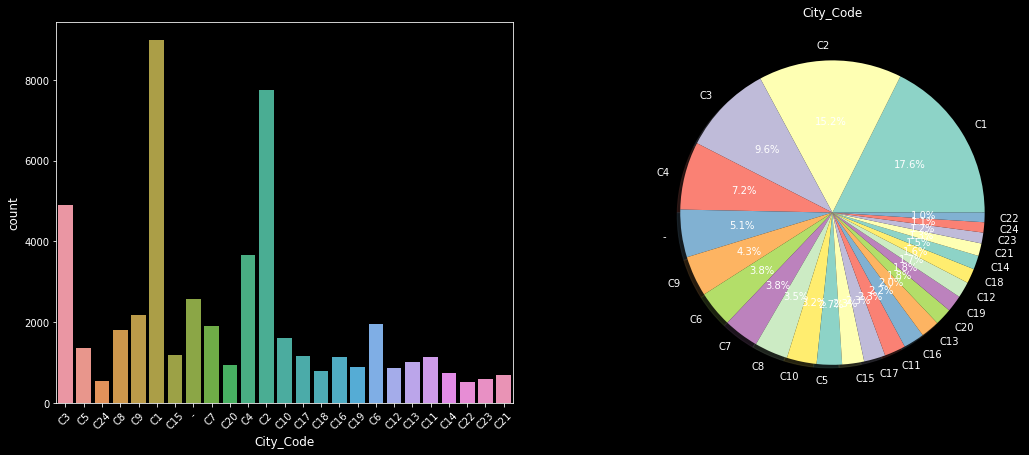

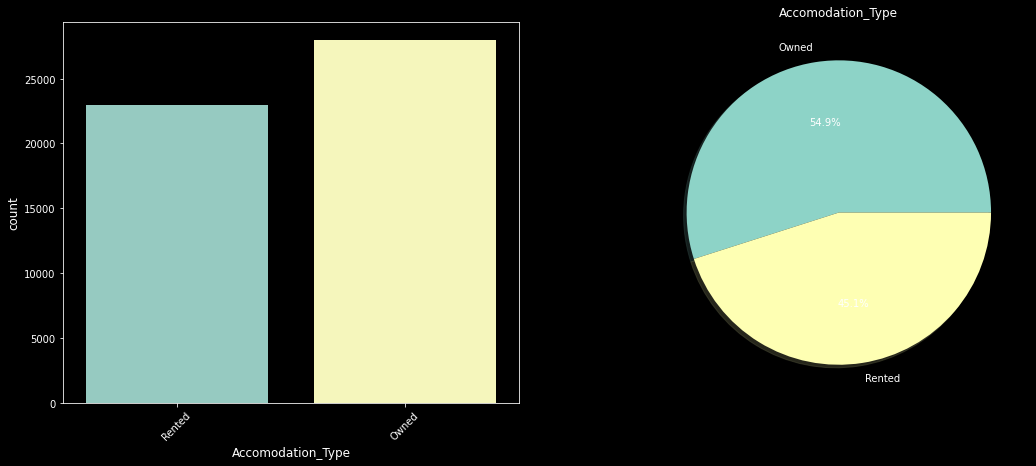

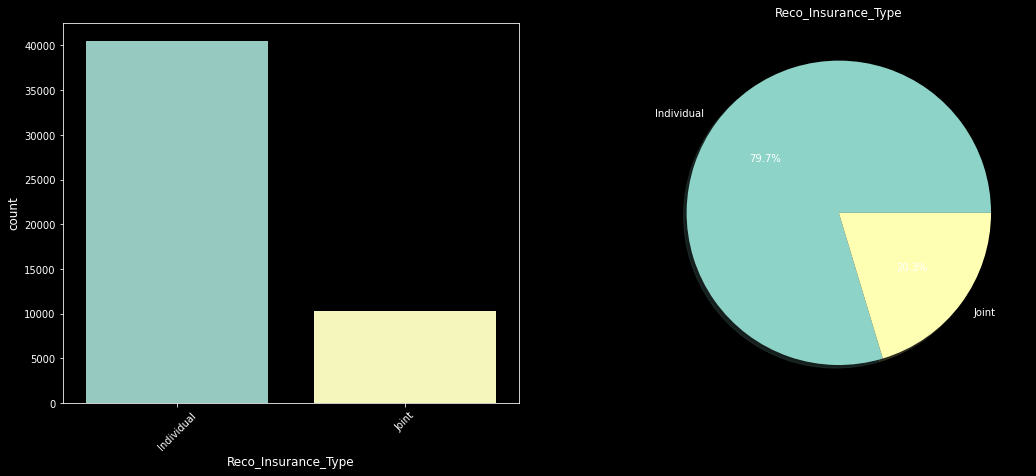

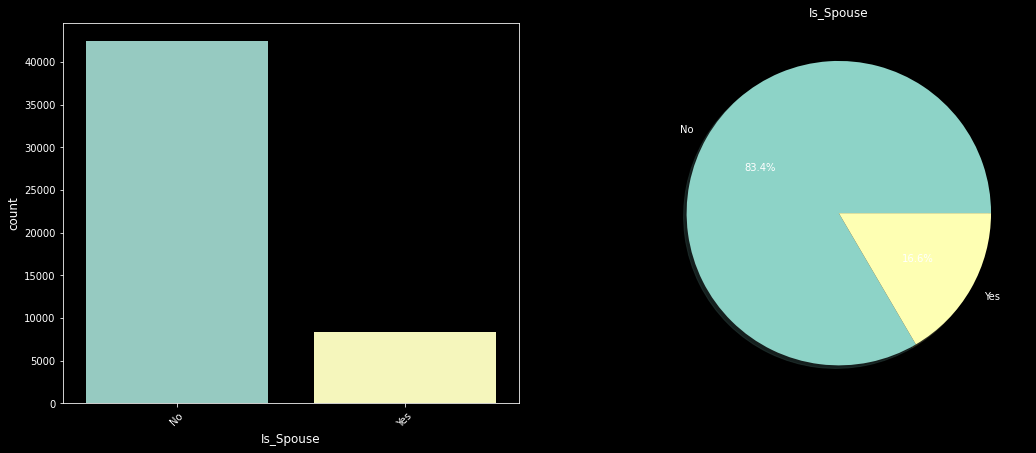

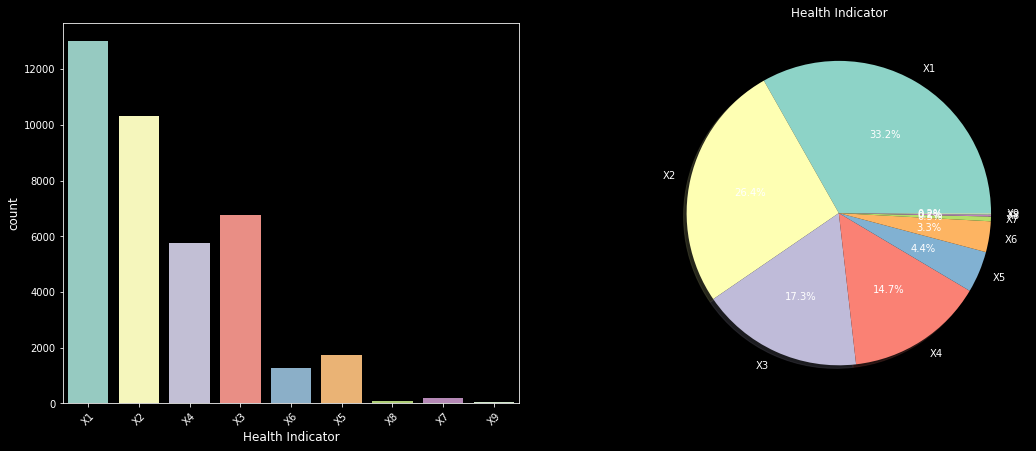

In [62]:
for col in col_cat:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.countplot(x=df[col], ax=ax[0], hue=df[y_label] if CLASSIFICATION else None).set_xlabel(f"{col}")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
    ax[1].pie(x=df[col].value_counts(), autopct="%.1f%%", shadow=True, labels=df[col].value_counts().index)
    ax[1].set_title(col)
plt.show()

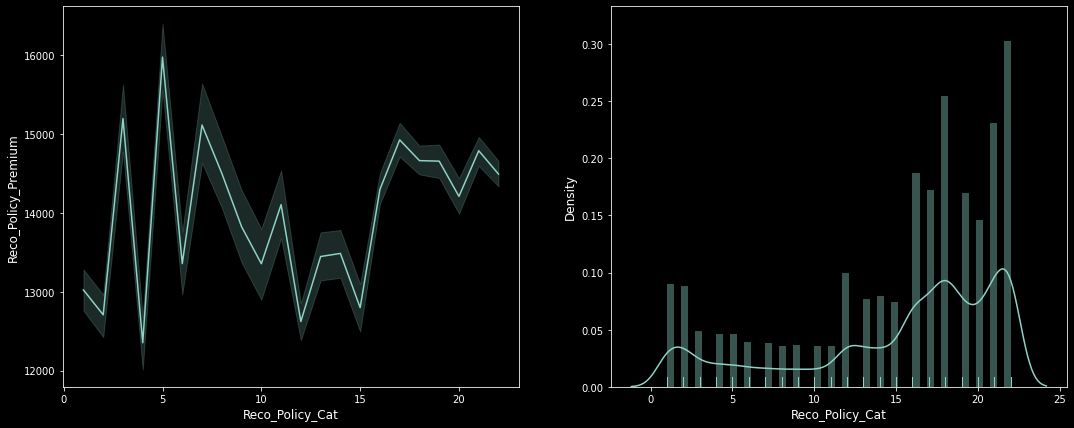

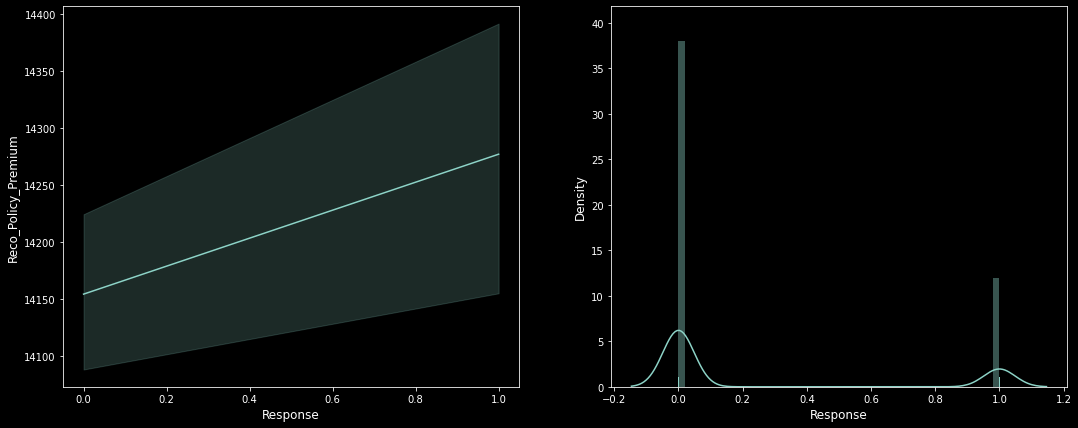

In [63]:
for col in col_num_disc + ([y_label] if CLASSIFICATION else []):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.lineplot(x=df[col], y=df[y_label], ax=ax[0]).set_xlabel(f"{col}")
    sns.distplot(x=df[col], ax=ax[1], rug=True).set_xlabel(f"{col}")
plt.show()

In [64]:
transformation_table = {
    "log": [],
    "log1p": [],
    "reciprocal": [],
    "sqrt": [],
    "exp": ["Upper_Age"],
    "boxcox": [],
    "boxcox1": [],
    "cap": [],
    "drop": [],
    "keep": df.columns.tolist(),
}
for transform, cols in transformation_table.items():
    if cols:
        col_outlier = [col for col in col_num_cont + ([] if CLASSIFICATION else [y_label]) if col in cols]
        q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
        iqr = q3 - q1
        lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
        condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
        print("-------------------------------------------------------")
        print(f"Performing {transform} transformation on cols {cols}.")
        print(f"Current Shape: {df.shape}.")
        print("-------------------------------------------------------")
        print(f"Scanning for outliers in {col_outlier}.")
        print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
        print("-------------------------------------------------------")
        print(f"upper_range:\n{upper_range}")
        print("-------------------------------------------------------")
        print(f"lower_range:\n{lower_range}")
        print("-------------------------------------------------------")
        if transform == "keep":
            print(f"Outliers have been kept {df.shape}.")
        elif transform == "cap":
            for col in col_outlier:
                df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
                df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
            print(f"Outliers have been capped {df.shape}.")
        elif transform == "drop":
            df = df[condition]
            print(f"Outliers have been removed {df.shape}.")
        elif transform == "log":
            for col in col_outlier:
                df[col] = np.log(df[col])
            print(f"Outliers have been log transformed {df.shape}.")
        elif transform == "log1p":
            for col in col_outlier:
                df[col] = np.log1p(df[col])
            print(f"Outliers have been log1p transformed {df.shape}.")
        elif transform == "reciprocal":
            for col in col_outlier:
                df[col] = (1 / df[col])
            print(f"Outliers have been reciprocal transformed {df.shape}.")
        elif transform == "sqrt":
            for col in col_outlier:
                df[col] = (df[col] ** 0.5)
            print(f"Outliers have been sqrt transformed {df.shape}.")
        elif transform == "exp":
            for col in col_outlier:
                df[col] = (df[col] ** (1/1.2))
            print(f"Outliers have been exp transformed {df.shape}.")
        elif transform == "boxcox":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col])[0]
            print(f"Outliers have been boxcox transformed {df.shape}.")
        elif transform == "boxcox1":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col] + 1)[0]
            print(f"Outliers have been boxcox1 transformed {df.shape}.")
        print("\n\n")

-------------------------------------------------------
Performing exp transformation on cols ['Upper_Age'].
Current Shape: (50882, 9).
-------------------------------------------------------
Scanning for outliers in ['Upper_Age'].
Outliers Percentage: 0.00%
-------------------------------------------------------
upper_range:
Upper_Age   105.50
dtype: float64
-------------------------------------------------------
lower_range:
Upper_Age   -18.50
dtype: float64
-------------------------------------------------------
Outliers have been exp transformed (50882, 9).



-------------------------------------------------------
Performing keep transformation on cols ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Is_Spouse', 'Health Indicator', 'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'].
Current Shape: (50882, 9).
-------------------------------------------------------
Scanning for outliers in ['Upper_Age', 'Reco_Policy_Premium'].
Outliers Percentage: 1.61%
--

-------------------------------------------------------
Upper_Age
Skew: 0.15
Kurtosis: -1.26


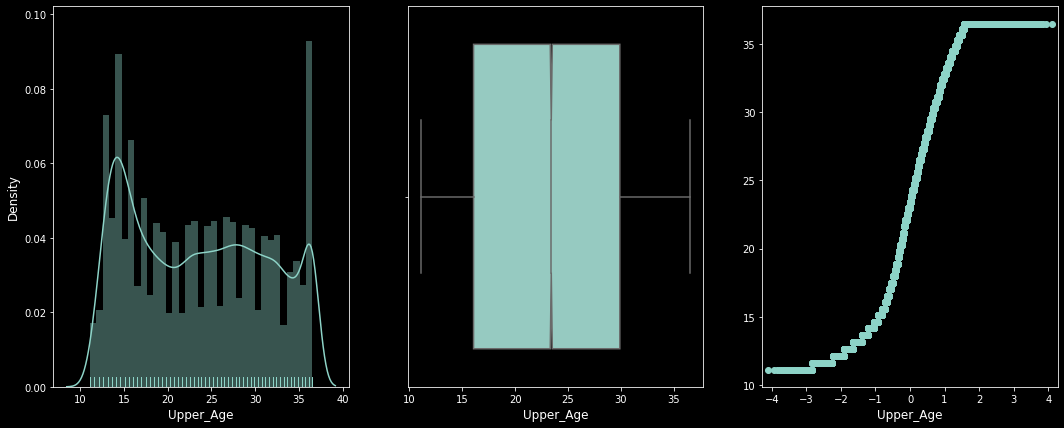

-------------------------------------------------------
Reco_Policy_Premium
Skew: 0.78
Kurtosis: 0.42


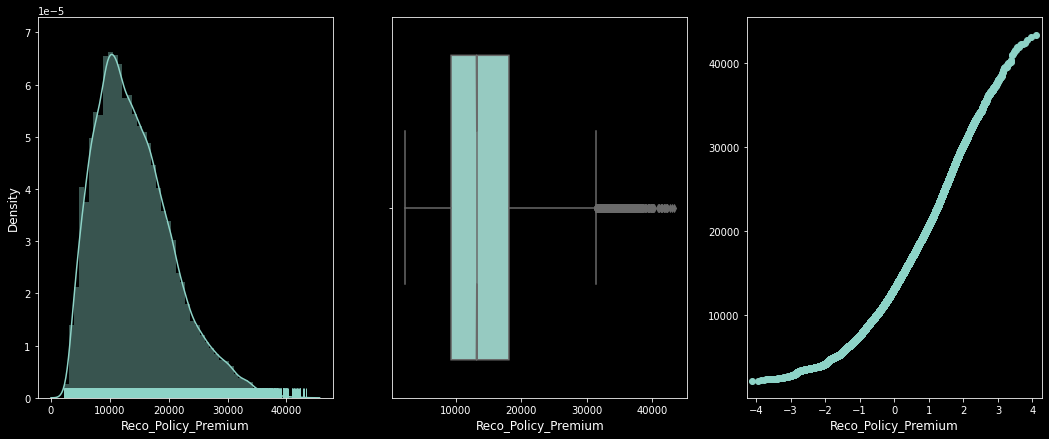

In [65]:
for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.distplot(x=df[col], ax=ax[0], rug=True).set_xlabel(f"{col}")
    sns.boxplot(x=df[col], ax=ax[1], notch=True).set_xlabel(f"{col}")
    sm.qqplot(data=df[col], ax=ax[2], xlabel=col, ylabel="")
    print("-------------------------------------------------------")
    print(f"{col}\nSkew: {df[col].skew(axis=0, skipna=True):.2f}\nKurtosis: {df[col].kurtosis(axis=0, skipna=True):.2f}")
    plt.show()

In [66]:
# for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
for col in []:
    for trans in ["keep", "log", "log1p", "reciprocal", "sqrt", "exp", "boxcox", "boxcox1"]:
        try:
            fig, ax = plt.subplots(nrows=1, ncols=3)
            if trans == "keep":
                x = df[col]
            elif trans == "log":
                x = np.log(df[col])
            elif trans == "log1p":
                x = np.log1p(df[col])
            elif trans == "reciprocal":
                x=(1 / df[col])
            elif trans == "sqrt":
                x=(df[col] ** 0.5)
            elif trans == "exp":
                x=(df[col] ** (1/1.2))
            elif trans == "boxcox":
                x=pd.Series(stat.boxcox(df[col])[0], name=col)
            else:
                x=pd.Series(stat.boxcox(df[col] + 1)[0], name=col)
            sns.distplot(x=x, ax=ax[0], rug=True).set_xlabel(f"{col}")
            sns.boxplot(x=x, ax=ax[1], notch=True).set_xlabel(f"{col}")
            sm.qqplot(data=x, ax=ax[2], xlabel=col, ylabel="")
        except Exception:
            pass
        finally:
            for i in range(3):
                ax[i].set_title(f"{trans.title()} Transformation")
            print("-------------------------------------------------------")
            print(f"{col} {trans.title()} Transformation\nSkew: {x.skew(axis=0, skipna=True):.2f}\nKurtosis: {x.kurtosis(axis=0, skipna=True):.2f}")
            plt.show()

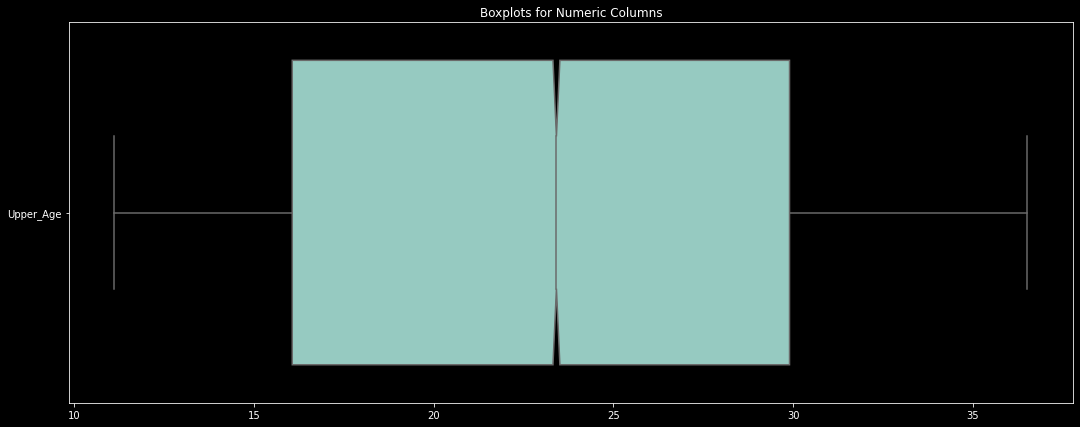

In [67]:
if col_num_cont:
    plt.title("Boxplots for Numeric Columns")
    sns.boxplot(data=df[[col for col in col_num_cont]], orient="h", notch=True)
    plt.show()

In [68]:
display(df.describe().T.style.background_gradient(cmap="Blues").format("{:.2f}"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues").format("{:.2f}"))

,count,mean,std,min,25%,50%,75%,max
Upper_Age,50882.00,23.55,7.67,11.12,16.07,23.42,29.90,36.52
Reco_Policy_Cat,50882.00,15.12,6.34,1.00,12.00,17.00,20.00,22.00
Reco_Policy_Premium,50882.00,14183.95,6590.07,2280.00,9248.00,13178.00,18096.00,43350.40
Response,50882.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00


,0.01,0.99
Upper_Age,11.63,36.52
Reco_Policy_Cat,1.00,22.00
Reco_Policy_Premium,3804.00,33024.00
Response,0.00,1.00


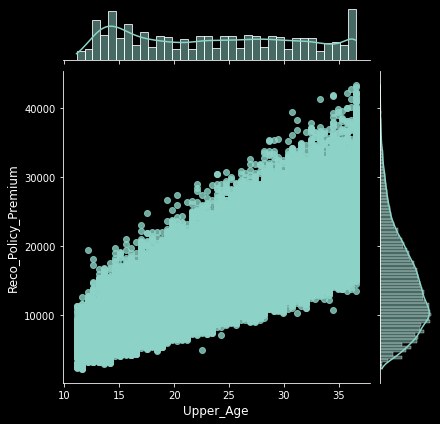

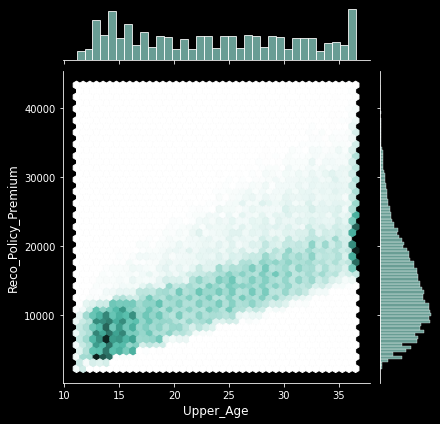

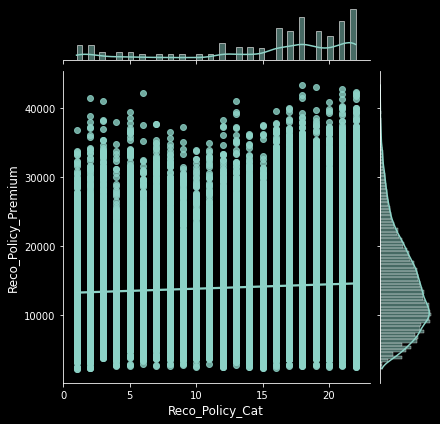

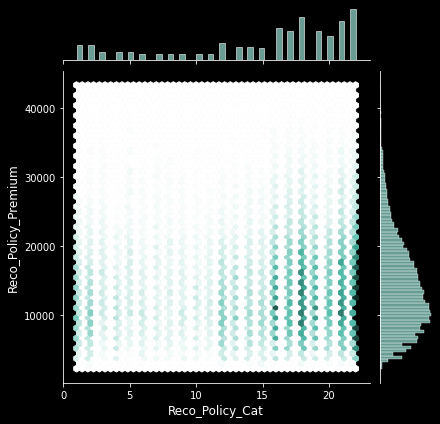

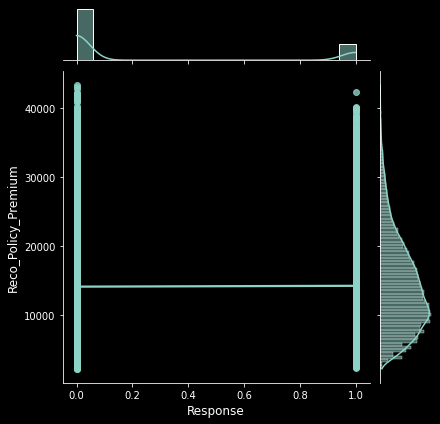

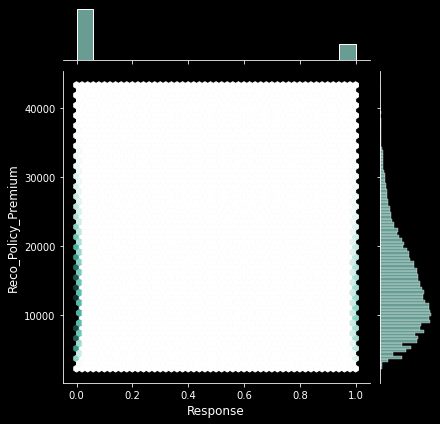

In [69]:
for col in col_num:
    if CLASSIFICATION:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        sns.swarmplot(x=y_label, y=col, data=df, color="grey", alpha=0.7, ax=ax)
        sns.boxenplot(x=y_label, y=col, data=df, ax=ax)
    else:
        sns.jointplot(x=col, y=y_label, hue=None, data=df, kind="reg")
        sns.jointplot(x=col, y=y_label, hue=None, data=df, kind="hex")
    plt.show()

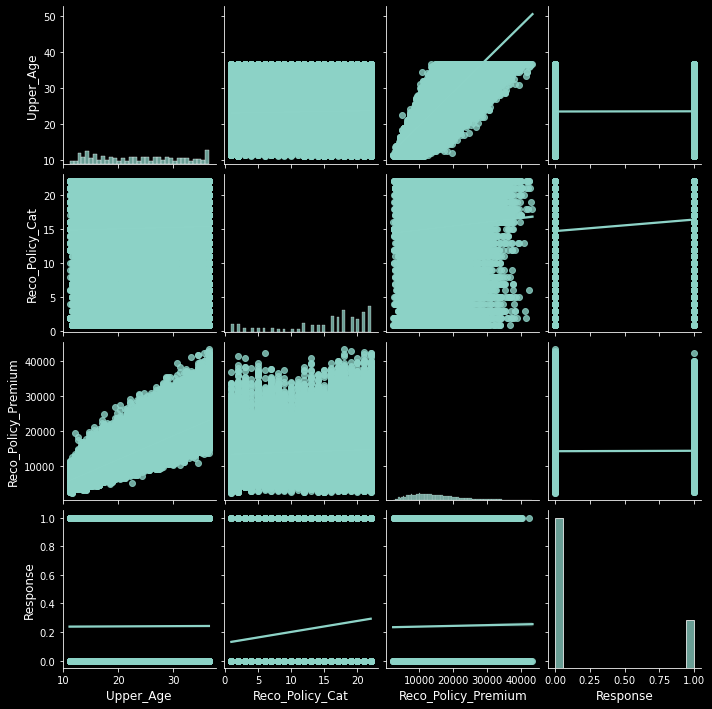

In [70]:
sns.pairplot(df, hue=y_label if CLASSIFICATION else None, kind="reg")

Target looks like regression


[array([[<AxesSubplot:title={'center':'F=8.59E+04'}, xlabel='Upper_Age', ylabel='Reco_Policy_Premium'>,
         <AxesSubplot:title={'center':'F=1.90E+02'}, xlabel='Reco_Policy_Cat'>]],
       dtype=object),
 array([[<AxesSubplot:title={'center':'F=2.84E-01'}, xlabel='Reco_Policy_Premium', ylabel='City_Code'>,
         <AxesSubplot:title={'center':'F=1.99E-01'}, xlabel='Reco_Policy_Premium', ylabel='Accomodation_Type'>,
         <AxesSubplot:title={'center':'F=9.09E-02'}, xlabel='Reco_Policy_Premium', ylabel='Reco_Insurance_Type'>],
        [<AxesSubplot:title={'center':'F=4.50E-02'}, xlabel='Reco_Policy_Premium', ylabel='Is_Spouse'>,
         <AxesSubplot:title={'center':'F=6.25E-03'}, xlabel='Reco_Policy_Premium', ylabel='Health Indicator'>,
         <AxesSubplot:title={'center':'F=4.14E-03'}, xlabel='Reco_Policy_Premium', ylabel='Response'>]],
       dtype=object)]

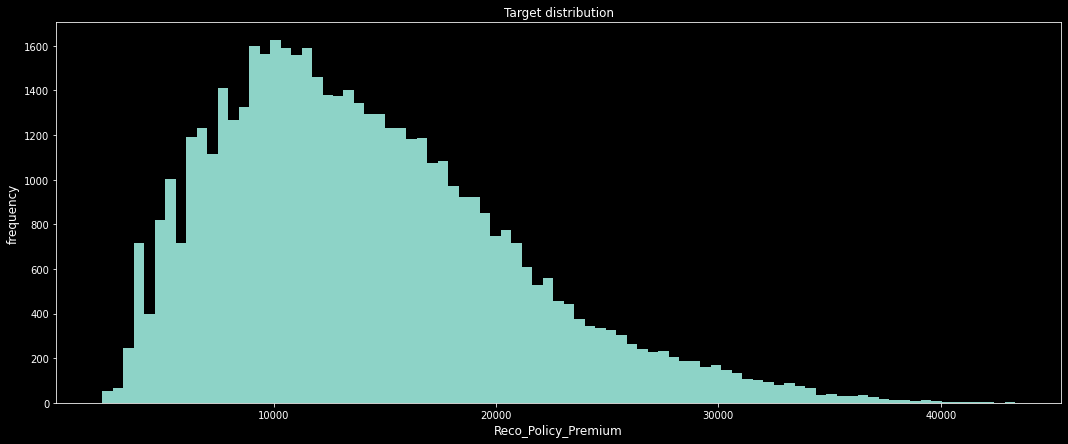

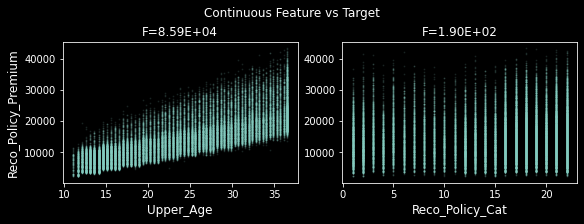

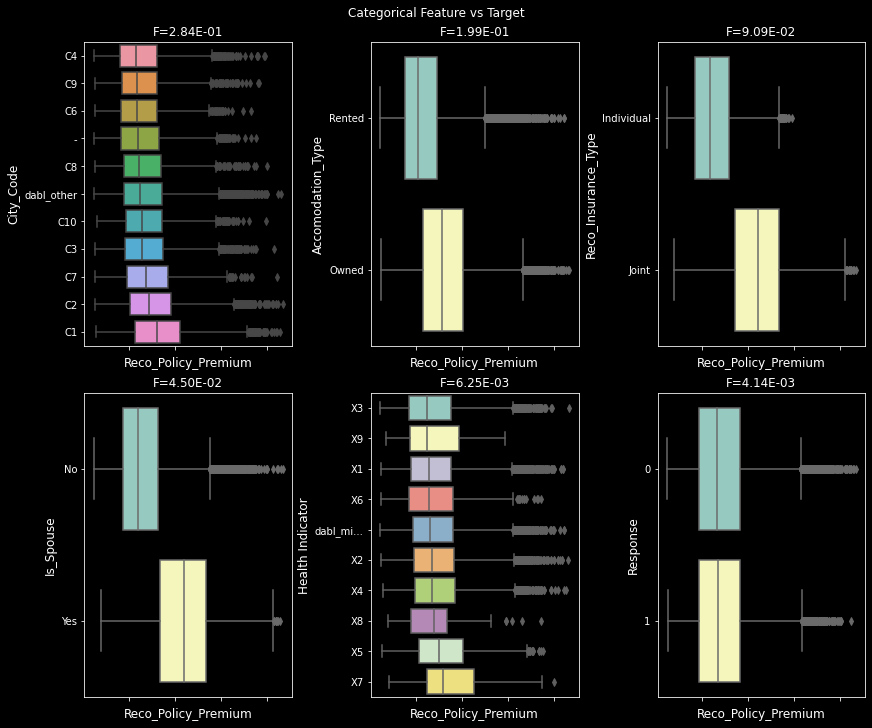

In [71]:
plot(df.drop(y_label, axis=1), df[y_label])

In [72]:
X, y = df.drop(y_label, axis=1), df[y_label]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=[None, y, y][CLASSIFICATION],
    random_state=RANDOM_STATE,
)
preprocessor_cat_ohe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)),
)
preprocessor_num_disc = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_num_cont = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_col = make_column_transformer(
    (preprocessor_cat_oe, col_cat_oe),
    (preprocessor_cat_ohe, col_cat_ohe),
    (preprocessor_num_disc, col_num_disc),
    (preprocessor_num_cont, col_num_cont),
    sparse_threshold=0
)
preprocessor = make_pipeline(
    (preprocessor_col),
    ([MinMaxScaler(), StandardScaler()][SCALER]),
    (VarianceThreshold(threshold=0)),
    (PCA())
)
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train), y_train
X_test_processed, y_test_processed = preprocessor.transform(X_test), y_test
if CLASSIFICATION:
    class_weights = {i: w for i, w in enumerate(class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_processed), y=y_train_processed))}
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.despine(left=True)
    sns.countplot(y, ax=ax[0]).set_xlabel("y")
    sns.countplot(y_train, ax=ax[1]).set_xlabel("y_train")
    sns.countplot(y_train_processed, ax=ax[2]).set_xlabel("y_train_processed")
    plt.show()
    print("-------------------------------------------------------")
    print(f"class_weights: {class_weights}")
    print("-------------------------------------------------------")
    print(f"y:\n{y.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")

-------------------------------------------------------
col_cat_oe (1): ['Health Indicator']
col_cat_ohe (4): ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse']
col_num_disc (2): ['Reco_Policy_Cat', 'Response']
col_num_cont (1): ['Upper_Age']
-------------------------------------------------------
total cols for preprocessor: 8
-------------------------------------------------------
X: (50882, 8)	X_train: (40705, 8)	X_train_processed:(40705, 31)	X_test: (10177, 8)		X_test_processed:(10177, 31)
y: (50882,)	y_train: (40705,)		y_train_processed:(40705,)	y_test: (10177,)		y_test_processed:(10177,)
-------------------------------------------------------


In [73]:
def build_auto_model():
    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(clean(df), target_col=y_label)
    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(clean(df), target_col=y_label)


def build_ml_model():
    tests = [
        {
            "model": make_pipeline_imb(
                preprocessor_col,
                [MinMaxScaler(), StandardScaler()][SCALER],
                SMOTE(random_state=RANDOM_STATE),
                VarianceThreshold(threshold=0),
                PCA(),
                SelectPercentile(),
                RandomForestClassifier() if CLASSIFICATION else LinearRegression(),
            )
            if OVERSAMPLE
            else make_pipeline_imb(
                preprocessor_col,
                [MinMaxScaler(), StandardScaler()][SCALER],
                VarianceThreshold(threshold=0),
                PCA(),
                SelectPercentile(),
                RandomForestClassifier() if CLASSIFICATION else LinearRegression(),
            ),
            "params": {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "columntransformer__pipeline-4__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
                "randomforestclassifier__n_estimators": [100, 150, 200, 500],
                "randomforestclassifier__criterion": ["gini", "entropy"],
                "randomforestclassifier__max_depth": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_split": [2, 5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_leaf": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__max_features": ["auto", "sqrt", "log2"],
            }
            if CLASSIFICATION
            else {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "columntransformer__pipeline-4__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
            },
        },
    ]
    for test in tests:
        rscv = RandomizedSearchCV(
            estimator=test["model"],
            param_distributions=test["params"],
            n_jobs=-1,
            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
            if CLASSIFICATION
            else 10,
            scoring="accuracy" if CLASSIFICATION else "r2",
            n_iter=10,
            return_train_score=True,
        )
        display(rscv)
        rscv.fit(X_train, y_train)
        print("===train============================")
        print(f"{rscv.best_score_ * 100:.2f}%\n{test['model'][-1]}\n{rscv.best_params_}")
        print("===params============================")
        display(pd.DataFrame(rscv.cv_results_).sort_values(by="rank_test_score"))
        print("===test============================")
        print(f"test score:{rscv.score(X_test, y_test) * 100:.2f}%")
        print("====end===========================\n")

    build_auto_model()
    print("-------------------------------------------------------")
    if CLASSIFICATION:
        classification_report_test = classification_report(
            y_test,
            rscv.predict(X_test),
            output_dict=True,
        )
        print(f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)")
        classification_report_train = classification_report(
            y_train,
            rscv.predict(X_train),
            output_dict=True,
        )
        print(f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)")
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test,
                rscv.predict(X_test),
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test,
                rscv.predict(X_test),
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        print(f"r2: {r2_score(y_test, rscv.predict(X_test)):.3f} neg_mean_squared_error: -{mean_squared_error(y_test, rscv.predict(X_test)):_.3f} (Test)")
        print(f"r2: {r2_score(y_train, rscv.predict(X_train)):.3f} neg_mean_squared_error: -{mean_squared_error(y_train, rscv.predict(X_train)):_.3f} (Train)")
        print("-------------------------------------------------------")
        plt.subplot(1, 3, 1)
        sns.regplot(y_train, y_train, color="darkorange", label="Truth")
        sns.regplot(
            y_test,
            rscv.predict(X_test),
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": rscv.predict(X_train),
                    "Residuals": rscv.predict(X_train) - y_train,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": rscv.predict(X_test),
                    "Residuals": rscv.predict(X_test) - y_test,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train - rscv.predict(X_train)))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test[:10].values,
                "Predicted": rscv.predict(X_test[:10]).round(1),
            }
        )
    )


def tune_dl_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("input_00", min_value=32, max_value=512, step=32),
            input_shape=X_train_processed.shape[1:],
        )
    )
    for i in range(1, hp.Int("num_layers", min_value=2, max_value=64)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"hidden_{i:02}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(
        keras.layers.Dense(
            units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
            activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
        )
    )
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss=["mean_squared_error", "binary_crossentropy", "sparse_categorical_crossentropy"][CLASSIFICATION],
        metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
    )
    return model


def train_dl_model():
    tuner.search(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        callbacks=[early_stop],
        epochs=MAX_TRIALS,
        validation_split=0.2,
        verbose=1,
    )
    tuner.results_summary()

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None
    )
    val_per_epoch = history.history[
        ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
    ]
    best_epoch = val_per_epoch.index([min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][CLASSIFICATION]) + 1

    plt.subplot(1, 2, 1)
    sns.lineplot(data=history.history[["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history[["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]], color="darkturquoise", linewidth=2.5)
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
    plt.grid()

    plt.subplot(1, 2, 2)
    sns.lineplot(data=history.history["loss"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_loss"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Loss", "Val Loss"], loc="upper right")
    plt.grid()
    plt.show()

    print(f"Best epoch: {best_epoch}")
    
    return best_epoch, best_hps


def build_dl_model(best_epoch, best_hps):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=best_epoch,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None
    )
    build_auto_model()
    print("-------------------------------------------------------")
    if CLASSIFICATION:
        classification_report_test = classification_report(
            y_test_processed,
            [
                model.predict(X_test_processed).round(),
                np.argmax(model.predict(X_test_processed), axis=1),
            ][CLASSIFICATION - 1],
            output_dict=True,
        )
        print(f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)")
        classification_report_train = classification_report(
            y_train_processed,
            [
                model.predict(X_train_processed).round(),
                np.argmax(model.predict(X_train_processed), axis=1),
            ][CLASSIFICATION - 1],
            output_dict=True,
        )
        print(f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)")
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        print(f"r2: {r2_score(y_test_processed, model.predict(X_test_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_test_processed, model.predict(X_test_processed)):_.3f} (Test)")
        print(f"r2: {r2_score(y_train_processed, model.predict(X_train_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_train_processed, model.predict(X_train_processed)):_.3f} (Train)")
        print("-------------------------------------------------------")
        plt.subplot(1, 3, 1)
        sns.regplot(y_train_processed, y_train_processed, color="darkorange", label="Truth")
        sns.regplot(
            y_test_processed,
            model.predict(X_test_processed).T[0],
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": model.predict(X_train_processed).T[0],
                    "Residuals": model.predict(X_train_processed).T[0] - y_train_processed,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": model.predict(X_test_processed).T[0],
                    "Residuals": model.predict(X_test_processed).T[0] - y_test_processed,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()
        
        plt.subplot(1, 3, 3)
        sns.distplot((y_train_processed - model.predict(X_train_processed).T[0]))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test_processed[:10].values,
                "Predicted": [
                    model.predict(X_test_processed[:10]).T[0],
                    model.predict(X_test_processed[:10]).T[0].round(),
                    np.argmax(model.predict(X_test_processed[:10]), axis=1),
                ][CLASSIFICATION],
            }
        )
    )
    return model


if SEARCH == "hyperband":
    tuner = Hyperband(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_00 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 64, 'step': 1, 'sampling': None}
hidden_01 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


2022-05-31 02:35:01.548799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 02:35:01.550228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 02:35:01.551441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 02:35:01.552594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 02:35:01.553626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0,
                                                                transformer_weights=None,
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('simpleimputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                                              copy=True,
                                                                                                              fill_value=None,
                                                                                                              missing_values=nan,
                                                                                                              strateg...
                   param_distributions={'columntransformer__pipeline-3__knnimputer__n_neighbors': [1,
                                                                                                   3,
                                                                                                   5,
                                                                                                   7,
                                                                                                   9],
                                        'columntransformer__pipeline-4__knnimputer__n_neighbors': [1,
                                                                                                   3,
                                                                                                   5,
                                                                                                   7,
                                                                                                   9],
                                        'selectpercentile__percentile': [10, 20,
                                                                         30, 40,
                                                                         50, 60,
                                                                         70, 80,
                                                                         90],
                                        'selectpercentile__score_func': [<function chi2 at 0x7fabbeef98c0>,
                                                                         <function f_classif at 0x7fabbeef93b0>]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='r2', verbose=0)

===train============================
80.92%
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                 normalize='deprecated', positive=False)
{'selectpercentile__score_func': <function f_classif at 0x7fabbeef93b0>, 'selectpercentile__percentile': 70, 'columntransformer__pipeline-4__knnimputer__n_neighbors': 9, 'columntransformer__pipeline-3__knnimputer__n_neighbors': 5}
===params============================


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectpercentile__score_func,param_selectpercentile__percentile,param_columntransformer__pipeline-4__knnimputer__n_neighbors,param_columntransformer__pipeline-3__knnimputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
8,2.11,0.11,0.03,0.00,<function f_classif at 0x7fabbeef93b0>,70,9,5,{'selectpercentile__score_func': <function f_c...,0.80,0.80,0.81,0.81,0.81,0.82,0.81,0.80,0.82,0.81,0.81,0.01,1,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.00
0,2.19,0.14,0.03,0.00,<function f_classif at 0x7fabbeef93b0>,60,1,7,{'selectpercentile__score_func': <function f_c...,0.80,0.80,0.80,0.81,0.81,0.81,0.81,0.80,0.81,0.80,0.81,0.01,2,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.00
4,2.28,0.42,0.03,0.00,<function f_classif at 0x7fabbeef93b0>,60,7,1,{'selectpercentile__score_func': <function f_c...,0.80,0.80,0.80,0.81,0.81,0.81,0.81,0.80,0.81,0.80,0.81,0.01,2,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.00
6,2.11,0.06,0.03,0.00,<function f_classif at 0x7fabbeef93b0>,50,7,3,{'selectpercentile__score_func': <function f_c...,0.79,0.80,0.80,0.81,0.81,0.81,0.81,0.80,0.81,0.80,0.81,0.01,4,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.00
1,2.23,0.28,0.03,0.01,<function f_classif at 0x7fabbeef93b0>,40,5,7,{'selectpercentile__score_func': <function f_c...,0.79,0.80,0.80,0.81,0.81,0.81,0.81,0.80,0.81,0.80,0.81,0.01,5,0.81,0.81,0.81,0.81,0.81,0.80,0.80,0.81,0.81,0.81,0.81,0.00
3,2.14,0.13,0.03,0.00,<function f_classif at 0x7fabbeef93b0>,40,1,7,{'selectpercentile__score_func': <function f_c...,0.79,0.80,0.80,0.81,0.81,0.81,0.81,0.80,0.81,0.80,0.81,0.01,5,0.81,0.81,0.81,0.81,0.81,0.80,0.80,0.81,0.81,0.81,0.81,0.00
7,2.25,0.22,0.03,0.01,<function f_classif at 0x7fabbeef93b0>,40,7,5,{'selectpercentile__score_func': <function f_c...,0.79,0.80,0.80,0.81,0.81,0.81,0.81,0.80,0.81,0.80,0.81,0.01,5,0.81,0.81,0.81,0.81,0.81,0.80,0.80,0.81,0.81,0.81,0.81,0.00
5,2.16,0.20,0.03,0.00,<function f_classif at 0x7fabbeef93b0>,10,3,5,{'selectpercentile__score_func': <function f_c...,0.61,0.60,0.61,0.63,0.63,0.62,0.61,0.62,0.61,0.60,0.61,0.01,8,0.61,0.61,0.61,0.61,0.61,0.61,0.61,0.61,0.61,0.61,0.61,0.00
2,0.38,0.07,0.00,0.00,<function chi2 at 0x7fabbeef98c0>,20,7,1,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.31,0.02,0.00,0.00,<function chi2 at 0x7fabbeef98c0>,90,3,9,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


===test============================
test score:80.79%
====end===========================

Running DummyRegressor()
r2: -0.000 neg_mean_squared_error: -43430860.757
=== new best DummyRegressor() (using r2):
r2: -0.000 neg_mean_squared_error: -43430860.757

Running DecisionTreeRegressor(max_depth=1)
r2: 0.477 neg_mean_squared_error: -22704387.899
=== new best DecisionTreeRegressor(max_depth=1) (using r2):
r2: 0.477 neg_mean_squared_error: -22704387.899

Running DecisionTreeRegressor(max_depth=5)
r2: 0.828 neg_mean_squared_error: -7473750.724
=== new best DecisionTreeRegressor(max_depth=5) (using r2):
r2: 0.828 neg_mean_squared_error: -7473750.724

Running Ridge(alpha=10)
r2: 0.817 neg_mean_squared_error: -7930049.828
Running Lasso(alpha=10)
r2: 0.815 neg_mean_squared_error: -8011007.087

Best model:
DecisionTreeRegressor(max_depth=5)
Best Scores:
r2: 0.828 neg_mean_squared_error: -7473750.724
-------------------------------------------------------
r2: 0.808 neg_mean_squared_error: -8_389

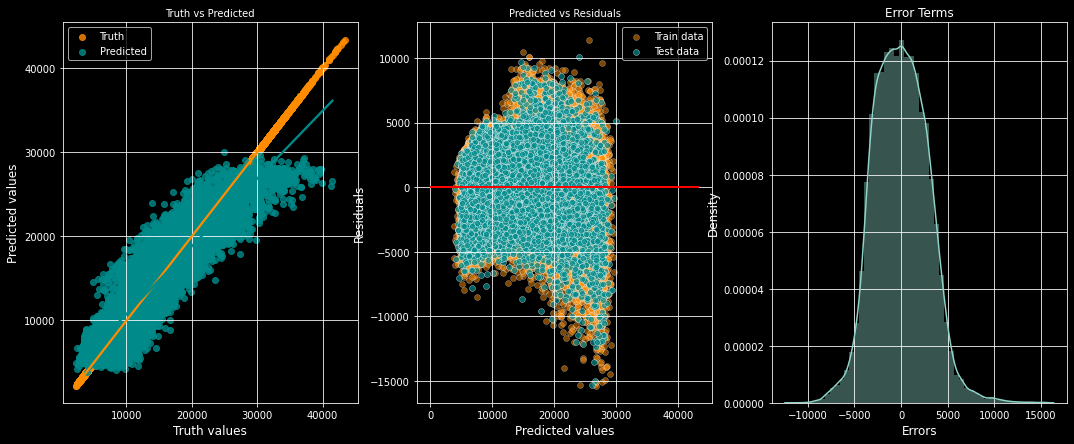

,Truth,Predicted
0,19200.00,18402.10
1,17004.00,14806.80
2,16665.60,18784.60
3,7920.00,9714.00
4,14190.00,10904.70
5,12562.00,10366.90
6,15696.00,19176.20
7,29205.00,27336.90
8,15574.00,15382.20
9,8106.00,10295.40


In [75]:
OVERSAMPLE = 0
build_ml_model()

Trial 30 Complete [00h 00m 05s]
val_mean_squared_error: 60371820.0

Best val_mean_squared_error So Far: 7380492.5
Total elapsed time: 00h 03m 59s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
input_00: 416
num_layers: 7
hidden_01: 288
dropout: 0.0
learning_rate: 0.001
hidden_02: 448
hidden_03: 480
hidden_04: 416
hidden_05: 224
hidden_06: 384
hidden_07: 416
hidden_08: 480
hidden_09: 192
hidden_10: 320
hidden_11: 128
hidden_12: 384
hidden_13: 480
hidden_14: 224
hidden_15: 32
hidden_16: 448
hidden_17: 448
hidden_18: 320
hidden_19: 256
hidden_20: 224
hidden_21: 224
hidden_22: 256
hidden_23: 128
hidden_24: 224
hidden_25: 96
hidden_26: 192
hidden_27: 64
hidden_28: 160
hidden_29: 96
hidden_30: 480
hidden_31: 416
hidden_32: 512
hidden_33: 256
hidden_34: 160
hidden_35: 480
hidden_36: 96
hidden_37: 320
hidden_38: 128
hidden_39: 256
hidden_40: 256
hidden_41: 224
hidden_42: 256
hidden_43: 384

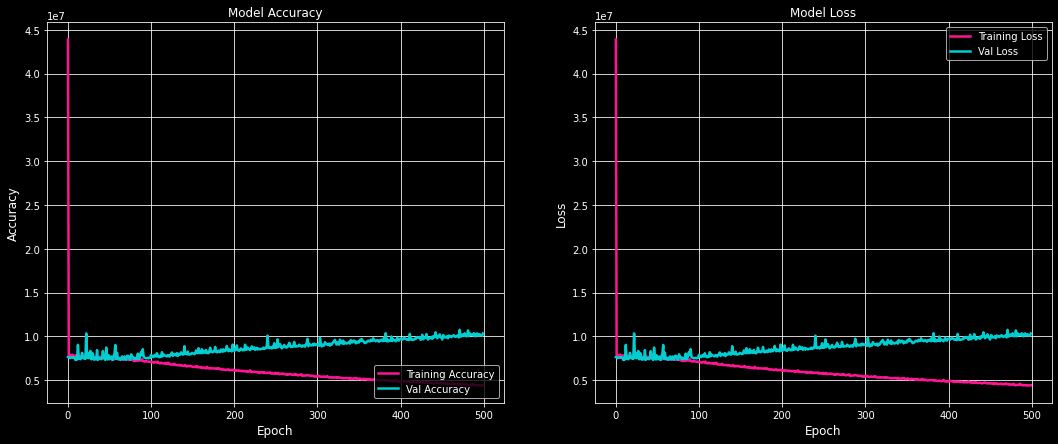

Best epoch: 55
Epoch 1/55
128/128 [==============================] - 1s 4ms/step - loss: 46248868.0000 - mean_squared_error: 46248868.0000 - val_loss: 7869690.0000 - val_mean_squared_error: 7869690.0000
Epoch 2/55
128/128 [==============================] - 0s 3ms/step - loss: 7894852.0000 - mean_squared_error: 7894852.0000 - val_loss: 7511768.0000 - val_mean_squared_error: 7511768.0000
Epoch 3/55
128/128 [==============================] - 0s 3ms/step - loss: 7791178.5000 - mean_squared_error: 7791178.5000 - val_loss: 7738535.0000 - val_mean_squared_error: 7738535.0000
Epoch 4/55
128/128 [==============================] - 0s 3ms/step - loss: 7780802.0000 - mean_squared_error: 7780802.0000 - val_loss: 7502226.0000 - val_mean_squared_error: 7502226.0000
Epoch 5/55
128/128 [==============================] - 0s 3ms/step - loss: 7784584.0000 - mean_squared_error: 7784584.0000 - val_loss: 7779886.0000 - val_mean_squared_error: 7779886.0000
Epoch 6/55
128/128 [==============================] -

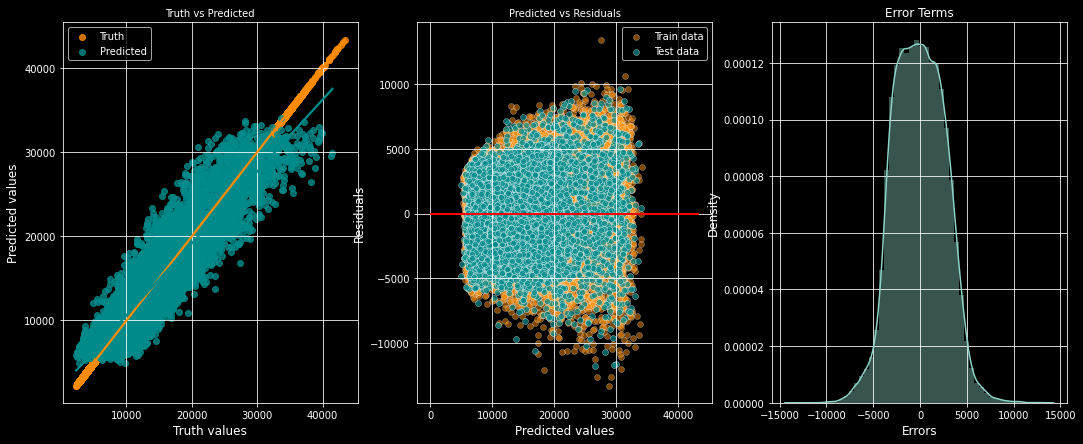

,Truth,Predicted
0,19200.00,19368.72
1,17004.00,15376.10
2,16665.60,20247.05
3,7920.00,8554.97
4,14190.00,10953.56
5,12562.00,10608.20
6,15696.00,18790.06
7,29205.00,30176.29
8,15574.00,14626.62
9,8106.00,10857.33


In [76]:
OVERSAMPLE = 0
best_epoch, best_hps = train_dl_model()
model = build_dl_model(best_epoch, best_hps)

2022-05-31 02:45:10.369064: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 416)               13312     
_________________________________________________________________
dense_20 (Dense)             (None, 288)               120096    
_________________________________________________________________
dropout_15 (Dropout)         (None, 288)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 448)               129472    
_________________________________________________________________
dropout_16 (Dropout)         (None, 448)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 480)               215520    
_________________________________________________________________
dropout_17 (Dropout)         (None, 480)              

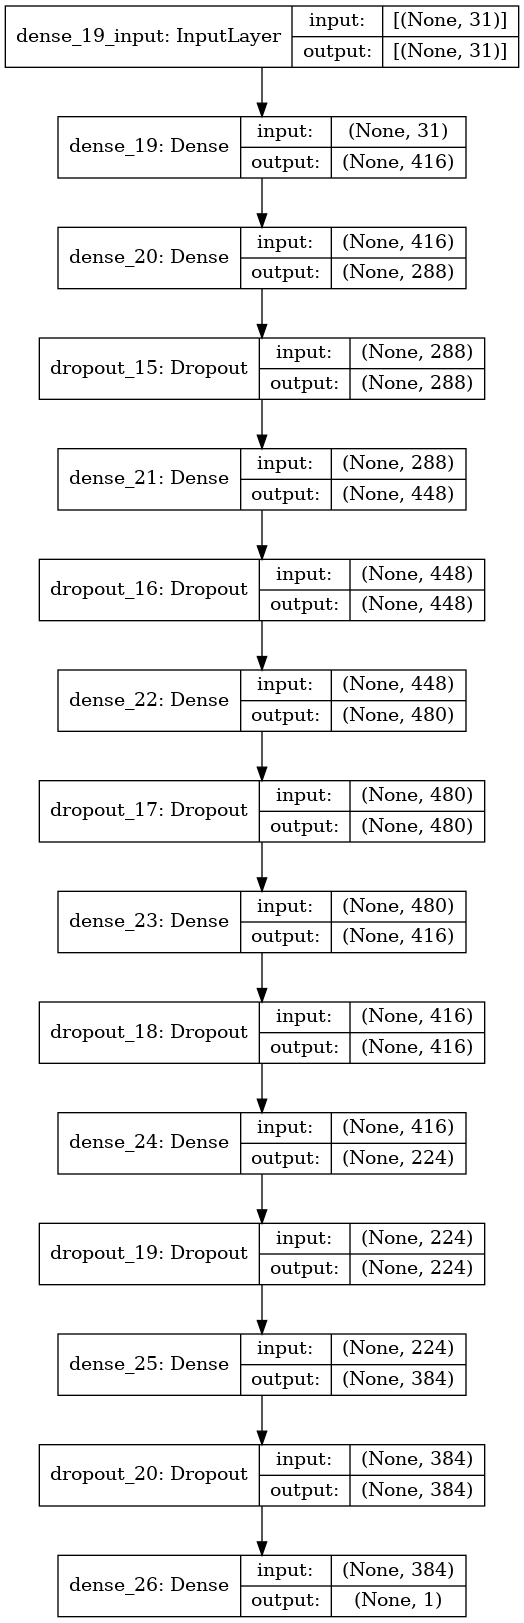

In [77]:
model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
dump(preprocessor, open(f"dl_preprocessor.pkl", "wb"))
model.summary()
plot_model(model, show_shapes=True)